# Understanding Crime in Chicago
### An exploratory data analysis (EDA) and visualization for crime in Chicago from 2005 to 2016

Fahd Alhazmi ([Twitter][1] | [Github][2])

  [1]: https://twitter.com/fahd09
  [2]: http://github.com/fahd09/

I don't know about you, but I have seen many notebooks and visualizations of crime in Chicago. Yet, as a current Chicago resident, I still have a lot of unanswered questions. In this notebook, I will explore crimes in Chicago from a perspective of a Chicago resident who wants to know more about the subject so he can better navigate his way through the city.

### Little introduction and motivation

**Crime in Chicago** is a very interesting topic for exploration for all kinds of reasons. Personally, I have been living in Chicago for a couple of months and crime here is always a topic of conversation with friends and family. Another reason is the availability of huge amounts of publicly available (high quality) crime datasets open for data scientists to mine and investigates such as this one.

In this notebook, I am going to explore more about crime in Chicago and try to answer few questions:

 - How has crime in Chicago changed across years? Was 2016 really [the bloodiest year in two decades][1]?
 - Are some types of crimes more likely to happen in specific locations or specific time of the day or specific day of the week than other types of crimes? 

  [1]: http://www.newsweek.com/2016/12/23/chicago-gangs-violence-murder-rate-532034.html

First, we import the required data science packages and get the data. I was not able to import data of previous periods but will continue to work this out.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# we will skip 2001 - 2005 due to bad quality

crimes1 = pd.read_csv('data/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('data/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes3 = pd.read_csv('data/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
crimes = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)

del crimes1
del crimes2
del crimes3

print('Dataset ready..')

print('Dataset Shape before drop_duplicate : ', crimes.shape)
crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
print('Dataset Shape after drop_duplicate: ', crimes.shape)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


Dataset ready..
Dataset Shape before drop_duplicate :  (6017767, 23)
Dataset Shape after drop_duplicate:  (4336556, 23)


We will not be using any of those columns in our analysis; so we filter them out 

In [2]:
crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District'], inplace=True, axis=1)

As we can tell from the first few rows, we have several columns that will help us answer our questions. We will use the 'Date' column to explore temporal patterns, 'Primary Type' and 'Location Description' to investigate their relationship with time (month of the year, time of the day, hour of the day, .. etc). Later we will use geolocation to map out safe spots (and times) in the city.

In [3]:
#Let's have a look at the first 3 records and see if we see what we expect
crimes.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Latitude,Longitude
0,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,41.981913,-87.771996
1,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,41.775733,-87.611920
2,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,41.769897,-87.593671


Sweet. Because we are dealing with dates, we need to convert the 'Date' column into a date format that is understandable by Python (and pandas).

In [4]:
# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

How many records we have and how many features for each record?

In [5]:
# of records X # of features
crimes.shape

(4336556, 10)

Let's make sure we are dealing with the right type of columns

In [6]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4336556 entries, 2006-04-02 13:00:00 to 2016-05-03 23:38:00
Data columns (total 10 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Latitude                float64
Longitude               float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 306.0+ MB


As 'Location Description', 'Description' and 'Primary Type' columns are actually categorical columns (or factors in R), we will only keep the most frequent categories and then cast them to a categorical type.

In [7]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'
#crimes.loc[crimes['Primary Type'].isin(type_to_change) , crimes.columns=='Primary Type'] = 'OTHER'

In [8]:
# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

At this point, I think we are ready to explore..

## Exploration and Visualization

At this point, I think we are done with all the preprocessing and cleaning. Now it is time to see what we got. In this section, I will make use of many of pandas functionality like resampling by a time frame and pivot_table (a function that somehow changes the way I think!). 

Let us begin by some generic queries, like how many records we have for each month ?

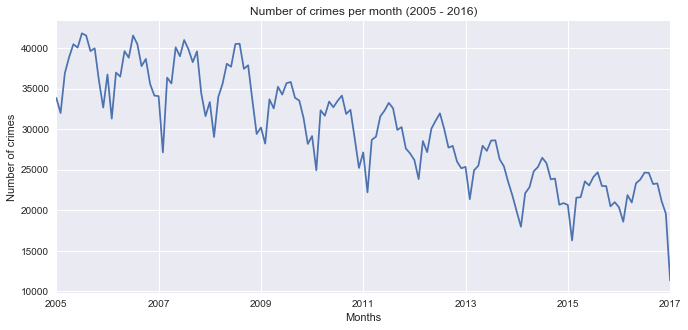

In [9]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2005 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

This chart shows a clear "periodic" pattern in the crimes over many years. I guess this very periodic pattern is an essential part of why crime a very predictable activity!. 

Before we take a deeper look into how other features could mediate such temporal consistency, I first want to answer our first question: **How crime has changed over the years? is it decreasing?** Let's have a look at what we have (from 2012 to 2016 for now).

In a previous chart, we already looked at the number of weekly crime records. Although it may not be very clear from the previous chart how crime have changed over the years, it still gives somehow similar numbers between 2015 and 2016. Here, we will take a finer scale to get the visualization right. I decided to look at the rolling sum of crimes of the past year. The idea is, for each day, we calculate the sum of crimes of the past year. If this rolling sum is decreasing, then we know for sure that crime rates have been decreasing during that year. On the other hand, if the rolling sum stays the same during a given year, then we can conclude that crime rates stayed the same.

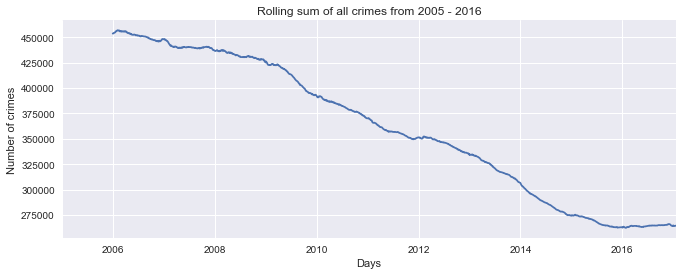

In [10]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2005 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

We see the line decreasing from 2006 up to some point around 2016 after which it stays around the same number of crimes. This all means that 2016 is really no better than 2015, but both years show a much better crime record (in total) than the previous years.

But..

could this figure be too good to be true? 

Let's separate crimes by type and see

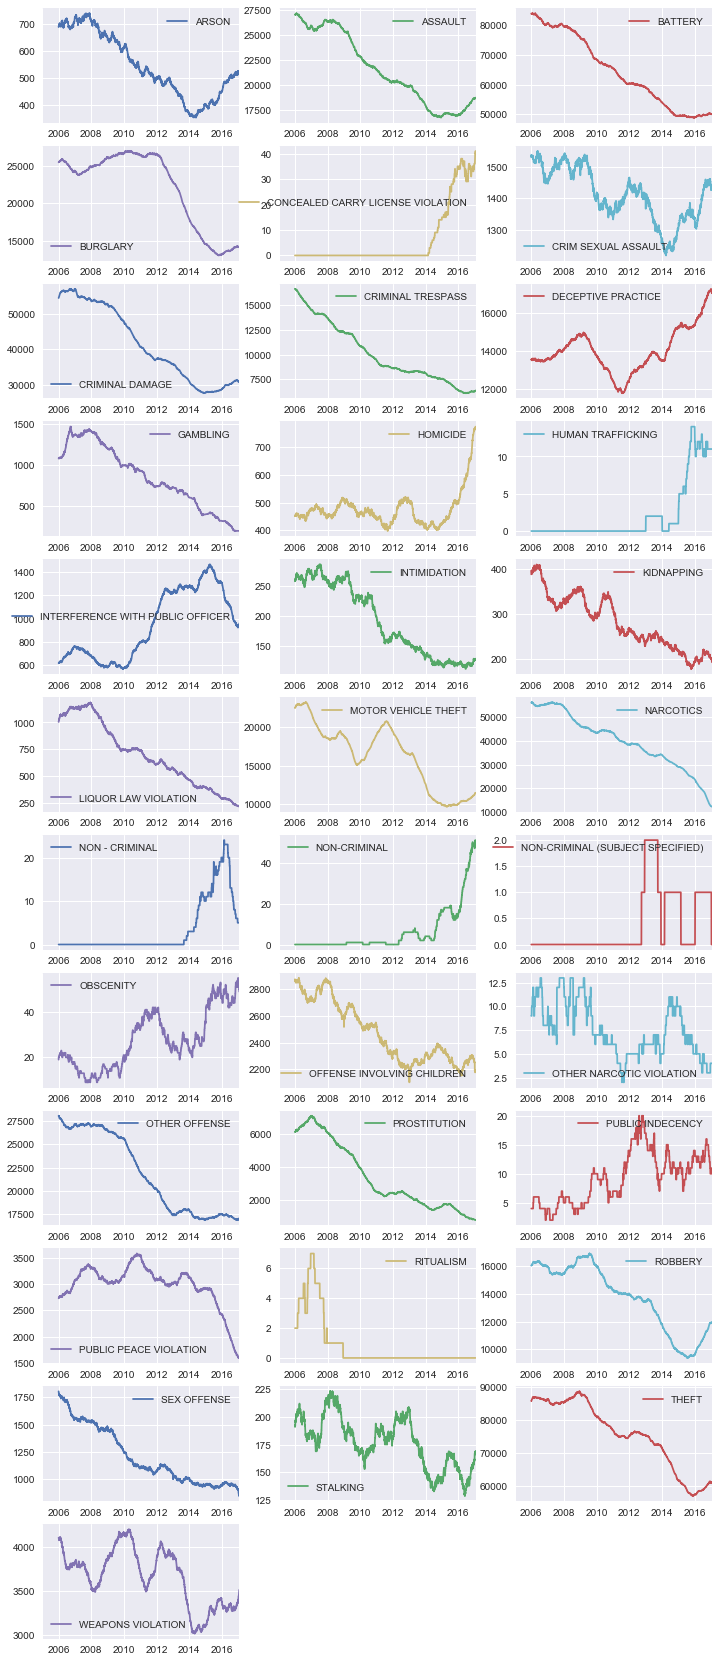

In [11]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

Hmmm. Lots of things can be said. I have stared at this plot myself for long because I was really excited to see the first figure and hoped it reflected an average trend toward decreasing crimes. But it is not the case. Some crime types are actually increasing all along like homicide and deceptive practice. Other types started to increase slightly before 2016 like theft, robbery and stalking (which may be the reason behind the trend we saw earlier).

## A general view of crime records by time, type and location

Not all crimes are the same. Some crimes types are more likely to occur than other types depending on the place and time. In this section, we will see how crimes differ between different places at different times.

The first thing we are going to look at is if there is a difference in the number of crimes during specific days of the week. Are there more crimes during weekdays or weekend? 

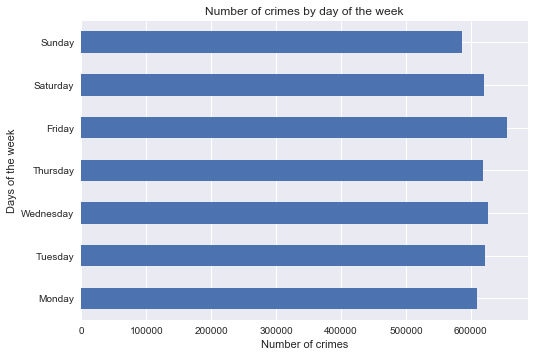

In [12]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

I don't really see something is different between days of the week. Maybe Friday has higher number of crime than other days, but this is still based on the counts and we are not really sure of it means it is always like this.

Now Let's look at crimes per month and see if certain months show more crimes than others.

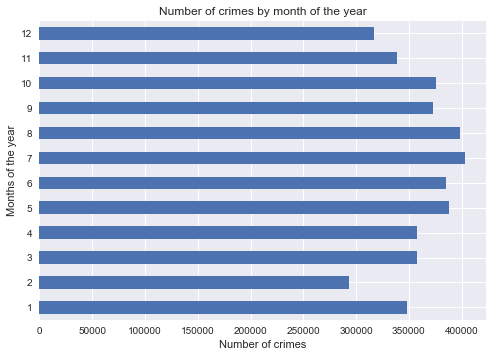

In [13]:
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

Crimes rates seem to peak at summer months! 

Let's have a look at the distribution of crime by their types, which crimes are most common among the top 20 most frequent crime types ?

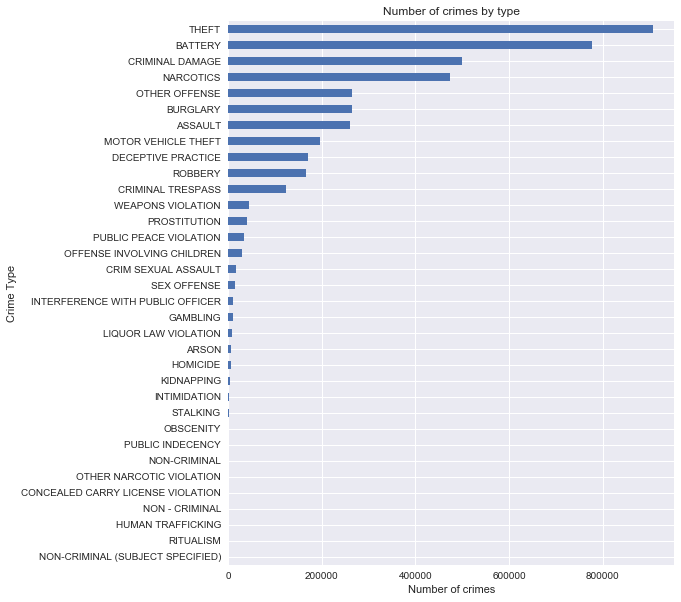

In [14]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

And similarly for crime location

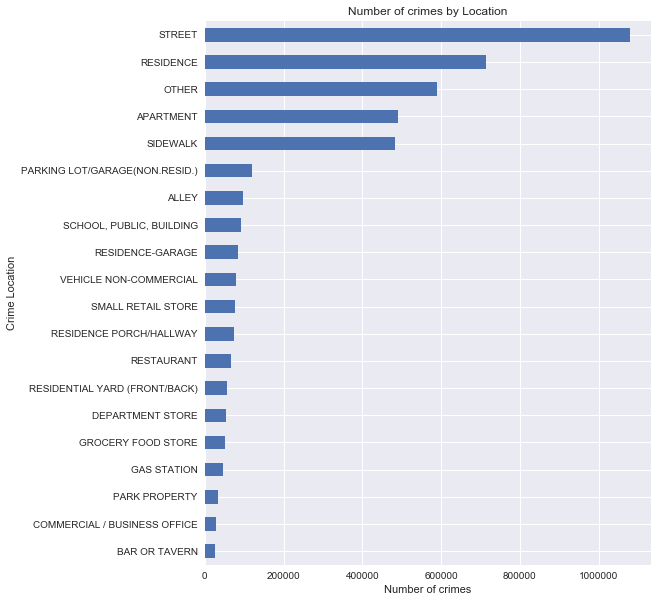

In [15]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

## Temporal analysis of crime rates by type and location

I am not so excited by the charts so far. They are boring. They do not show me interesting things. It only felt like they make sense. In this section, things are way different. We will directly address the second question in the introduction. 

Not all crimes are the same. Some crimes types are more likely to occur than other types depending on the place and time. In this section, we will see how crimes differ between different places at different times.

After seeing the base rates of each crime location and type, we will now assume that all crime types (and locations) have the same frequency or, in other words, they are all equal overall. We are interested in detecting how a specific crime type is different across all days of the week or hours of the day.

Is theft or burglary is more likely to occur at a weekday compared to a weekend? Are they more likely to happen in the morning vs evening or late night ? are they more likely to occur in a street vs a bar? 

Let's dig up using the fantastic 'pivot_table' from pandas.

In [16]:
hour_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_week     = crimes.pivot_table(values='ID', index=crimes.index.hour, columns=crimes.index.weekday_name, aggfunc=np.size).fillna(0)
hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)

Here I will make nice wrapper functions to make some minimal preprocessing and make the heatmap visualization. A trick I used to make heatmaps nicer looking is to use a clustering algorithm to sort the rows into meaningful groups and use group labels to re-sort our matrix.

In [17]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Before we go on, let me explain how we got those heatmaps. For each set of those pots, I re-scaled counts of crime records in each hour within each crime type to be z-scaled (to have a mean of zero and a unit standard deviation). So it is a "within-type/ across-hours" scaling that aims to show differences between frequencies of crimes at different hours. All types have the save "average" of crime counts, but not all hours have the same average. So a negative value indicate a lower frequency while a positive value indicate a higher frequency for that crime to occur in a particular hour.

First, let's see if there are "day crimes vs night crimes" thing. As you can see, some crimes have their peaks during the early morning (upper part of the heatmap), other crimes peak during the day (mid-part of the heatmap) and the final group of crimes peak at night (lower part of the heatmap

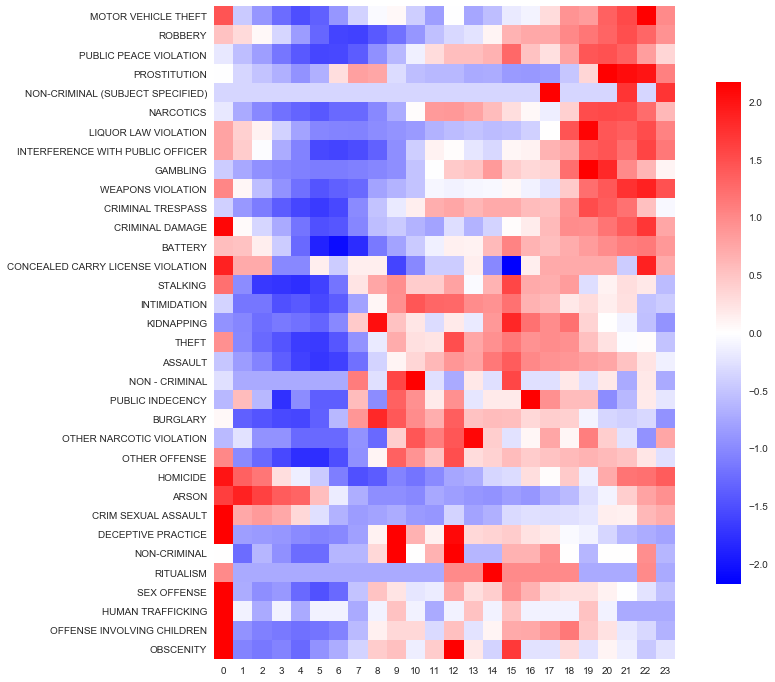

In [18]:
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_type)

Similarly, we will look at crime locations and see some locations are more likely to have crimes during the day vs. during the night. The upper part of the heatmap shows locations that have crime peaks during the day (with a couple of them peaking at 9AM). The mid-part shows locations that have crime peaks during the night ad finally the lower part (a single observation) shows that bars have crime peaks during early morning. 

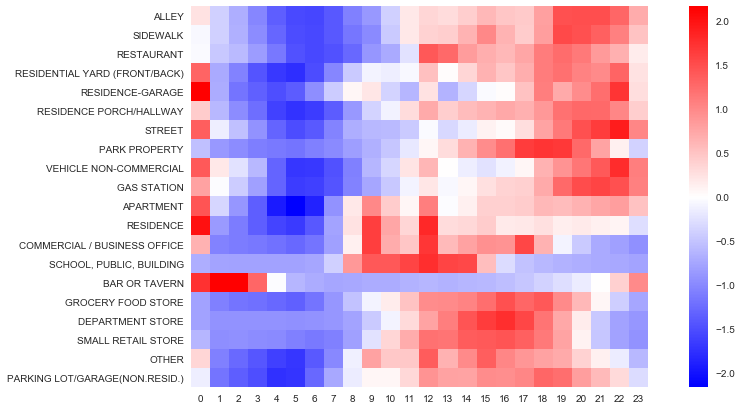

In [19]:
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)

But is this 'day crimes vs. night crimes" thing consistent during all days of the week? I mean, can't we expect weekends to show a different pattern in the timing of crimes? Sure they do.

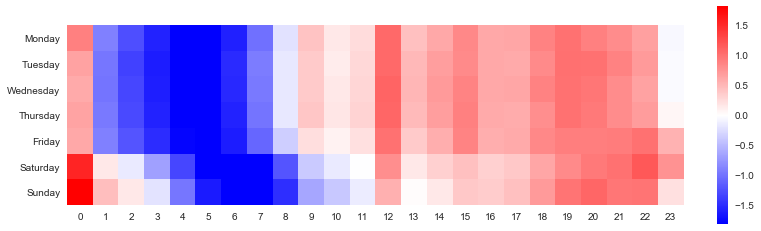

In [20]:
plt.figure(figsize=(12,4))
scale_and_plot(hour_by_week, ix=np.arange(7))

I am excited to see more about this "weekday crime vs. weekend crime" thing. So let's dig deeper and see of they have anything with crime types. 

The heatmap below indicates few interesting things (x-axis is days of the week). Some crimes types peak at specific days of the week (like Friday or Saturday). Other types are more like weekday crimes (showing in the mid-part of the heatmap) or weekend crimes (showing in the lower part of the heatmap).

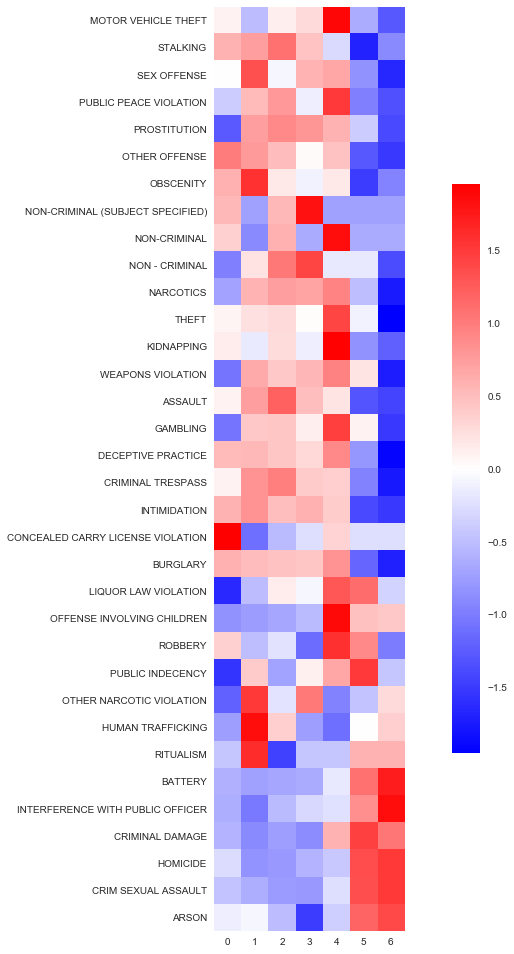

In [21]:
plt.figure(figsize=(17,17))
scale_and_plot(dayofweek_by_type)

Similarly, we will use crime locations instead of crime types to find, again, that there are weekday locations and weekend locations...

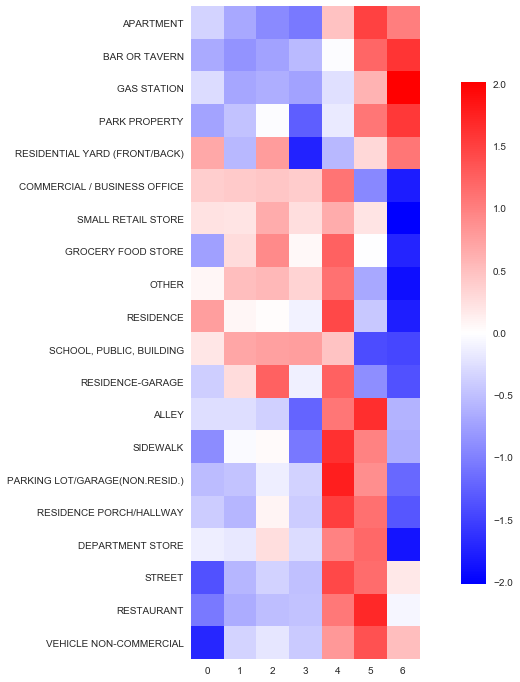

In [22]:
plt.figure(figsize=(15,12))
scale_and_plot(dayofweek_by_location)

## Where a certain crime type is most likely to happen?

In this section, we hope to answer another type of questions: for a given crime (like theft or sexual assault), what is the most likely location for this crime to happen? In this analysis, as with the previous ones, we take each crime type and re-normalize its location frequency to be between zero and one. This way, we can look at the top frequent locations of each crime type (darker red reflect a more frequent location).

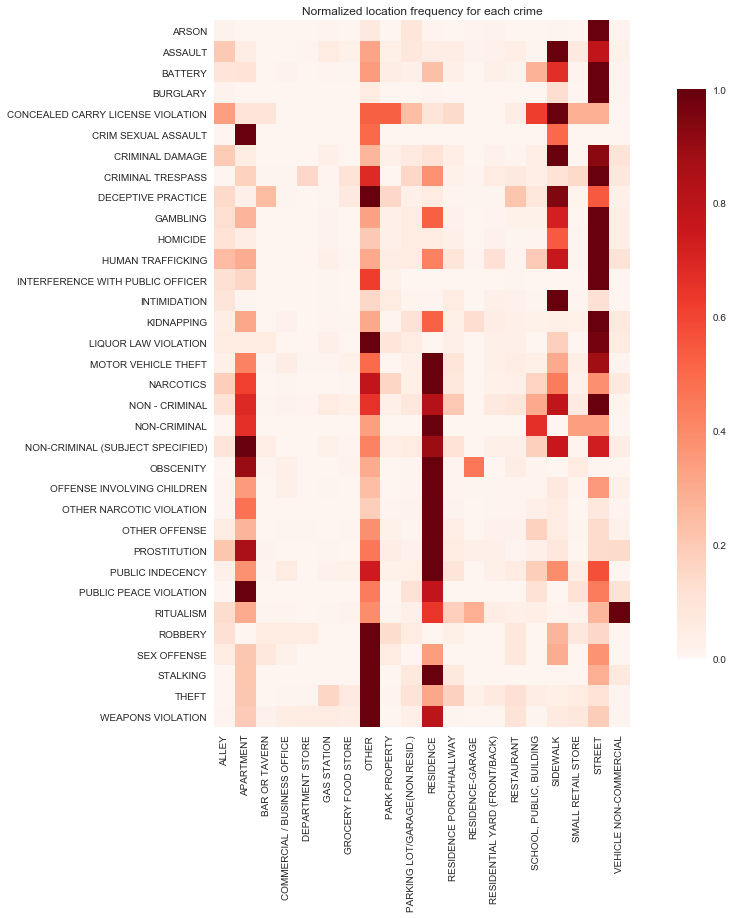

In [23]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

Well, it appears that most crimes occur at either apartments, residence, sidewalks, streets or 'other'. There are few notable exceptions here and there but those places are very frequent. This heatmap got me thinking that I probably should've used more than 20  categories. But that is "*left as an exercise for the reader"* ;)

There are still many ways to expand on this notebook. I am most interested in using the geo-coordinates in this analysis and find where are the safe/unsafe spots (according to crimes types), and the same thing for the safe/unsafe times and days. I will come back to address this once I figure out a way to give nice looking geo visualizations.

Final two things:

 - Please do not hesitate to **comment** if you have any feedback/comment/question.  
 - An **upvote** would be much appreciated.

Thanks for reading!